# Define Environment

In [ ]:
from typing import Dict
import numpy as np
import gym
from gym import spaces
import matplotlib as plt

class DotsAndBoxesEnv(gym.Env):
    def __init__(self):  
        super(DotsAndBoxesEnv, self).__init__()
        self.grid_size = (6, 6)
        self.state = self.create_all_lines(self.grid_size)  # Dict[str, bool] -> key, isClicked -> key format: h-0-1
        assert len(self.state) == 60
        self.done = False
        self.current_player = 1  # Player 1 starts

        # ✅ Action Space (total lines)
        self.action_space = spaces.Discrete(len(self.state))

        # ✅ Observation Space (binary representation of lines)
        self.observation_space = spaces.Box(low=0, high=1, shape=(len(self.state),), dtype=np.int8)

    def create_all_lines(self, size) -> Dict[str, bool]:
        lines = {}
        for i in range(size[0]):  
            for j in range(size[1]):
                if j < size[1] - 1:
                    lines[f"v-{i}-{j}"] = False
                if i < size[0] - 1:
                    lines[f"h-{i}-{j}"] = False
        lines = {key: lines[key] for key in sorted(lines.keys())}
        return lines

    def step(self, action: int):
        assert action < 60
        if self.done:
            return self._get_observation(), 0, self.done, {}

        all_lines = list(self.state.keys())
        selected_line_key = all_lines[action]

        if self.state[selected_line_key]:  # Line already clicked
            return self._get_observation(), -10, self.done, {}

        self.state[selected_line_key] = True  # Mark line as clicked

        reward = self.evaluate_board(selected_line_key)
        self.done = self.check_game_over()

        # Switch player ONLY IF no box was completed
        if reward == 0:
            self.current_player = 1 if self.current_player == 2 else 2
            reward = 0.1

        return self._get_observation(), reward, self.done, {}

    def evaluate_board(self, last_move: str):
        reward = 0
        parts = last_move.split("-")
        orientation, x, y = parts[0], int(parts[1]), int(parts[2])

        # Possible boxes affected by the last move
        affected_boxes = []

        if orientation == "v":
            if x > 0:
                affected_boxes.append((x - 1, y))
            if x < self.grid_size[0]:
                affected_boxes.append((x, y))
        elif orientation == "h": 
            if y > 0:
                affected_boxes.append((x, y - 1))
            if y < self.grid_size[1]:
                affected_boxes.append((x, y))

        # Check if any affected box is now completed
        for i, j in affected_boxes:
            if self.is_box_completed(i, j):
                reward = reward + 1  # A box was completed

        return reward

    def is_box_completed(self, i, j):
        """Check if a box at (i, j) is completed by verifying its four edges."""

        top = f"h-{i}-{j}"
        bottom = f"h-{i}-{j+1}"
        left = f"v-{i}-{j}"
        right = f"v-{i+1}-{j}"

        # Ensure all keys exist in self.state before accessing
        return (
            self.state.get(top, False) and
            self.state.get(bottom, False) and
            self.state.get(left, False) and
            self.state.get(right, False)
        )


    def check_game_over(self):
        return all(self.state.values())

    def reset(self):
        self.state = self.create_all_lines(self.grid_size)
        self.done = False
        self.current_player = 1  # Player 1 starts
        return self._get_observation()

    def _get_observation(self):
        return np.array(list(self.state.values()), dtype=np.int8)


# Train an RL Agent

Episode 1: Total Reward = 825.0
Episode 2: Total Reward = -1727.1
Episode 3: Total Reward = -607.1
Episode 4: Total Reward = 1967.0
Episode 5: Total Reward = 2039.0
Episode 6: Total Reward = 1033.0
Episode 7: Total Reward = 1493.0
Episode 8: Total Reward = 1875.0
Episode 9: Total Reward = 2361.0
Episode 10: Total Reward = 983.0
Episode 11: Total Reward = 1789.0
Episode 12: Total Reward = -2785.1
Episode 13: Total Reward = -133.0
Episode 14: Total Reward = 971.0
Episode 15: Total Reward = -2287.1
Episode 16: Total Reward = -1517.1
Episode 17: Total Reward = 807.0
Episode 18: Total Reward = 1239.0
Episode 19: Total Reward = -2247.1
Episode 20: Total Reward = -843.1
Episode 21: Total Reward = 2031.0
Episode 22: Total Reward = -1363.1
Episode 23: Total Reward = 1457.0
Episode 24: Total Reward = -2387.1
Episode 25: Total Reward = -851.1
Episode 26: Total Reward = -415.1
Episode 27: Total Reward = 377.0
Episode 28: Total Reward = -1127.1
Episode 29: Total Reward = 1399.0
Episode 30: Total Re

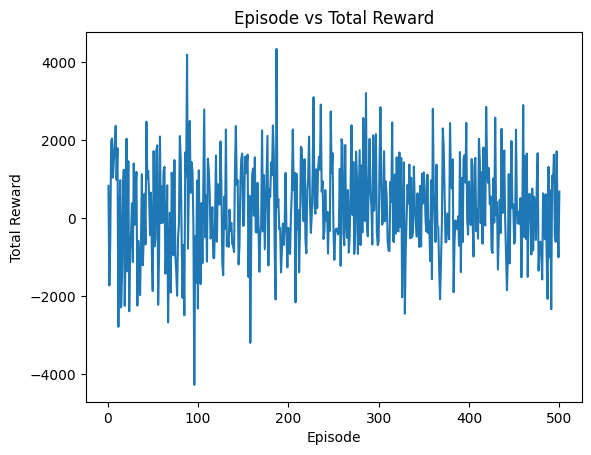

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import collections
import gym

TAU = 0.05

# Define the Q-network
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        assert input_dim == 60
        assert output_dim == 60
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)  # Q-values for each action

class DQNAgent:
    def __init__(self, env, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, batch_size=32, memory_size=10000):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size

        self.memory = collections.deque(maxlen=memory_size)  # Experience Replay Buffer

        self.policy_net = DQN(input_dim=env.observation_space.shape[0], output_dim=env.action_space.n)
        self.target_net = DQN(input_dim=env.observation_space.shape[0], output_dim=env.action_space.n)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def get_action(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()  # Explore
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            q_values = self.policy_net(state)
        return torch.argmax(q_values).item()  # Exploit

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return  # Skip training if not enough samples

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        # Compute Q-values
        q_values = self.policy_net(states).gather(1, actions).squeeze()

        # Compute target Q-values
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        # Compute loss
        loss = self.loss_fn(q_values, target_q_values)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, num_episodes=1000):
        rewards = []
        for episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            done = False
            while not done:
                if self.env.current_player == 2:
                    action = self.get_action(state)  # AI chooses action
                    next_state, reward, done, _ = self.env.step(action)  # Take action
                    self.store_experience(state, action, reward, next_state, done)
                    self.train_step()  # Update model
                    state = next_state
                    total_reward += reward

                elif self.env.current_player == 1:
                    # Here, the opponent plays randomly
                    action = self.env.action_space.sample()  # Opponent chooses random action
                    next_state, reward, done, _ = self.env.step(action)  # Take action
                    state = next_state
                    total_reward -= reward
            
            target_net_state_dict = self.target_net.state_dict()
            policy_net_state_dict = self.policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            self.target_net.load_state_dict(target_net_state_dict)

            # Decay epsilon for exploration-exploitation trade-off
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            print(f"Episode {episode + 1}: Total Reward = {total_reward}")

            rewards.append(total_reward)
            
        # Plotting
        import matplotlib.pyplot as plt
        plt.plot(range(1, num_episodes + 1), rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Episode vs Total Reward')
        plt.show()
    
    def get_sorted_actions_with_scores(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            q_values = self.policy_net(state_tensor).squeeze().numpy()  # Get Q-values for each action

        # Create a list of (action, q_value) pairs
        actions_with_scores = [(i, q_value) for i, q_value in enumerate(q_values)]

        # Sort the actions based on their Q-values in descending order (better actions first)
        sorted_actions = sorted(actions_with_scores, key=lambda x: x[1], reverse=True)

        return sorted_actions


# Create Environment
env = DotsAndBoxesEnv()

# Train the Agent
agent = DQNAgent(env)
agent.train(num_episodes=500)



# Evaluate the Trained Model

In [16]:
def evaluate_agent(agent, env, num_episodes=10):
    total_rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            if env.current_player == 1:
            # Get the action from the trained agent
                action = agent.get_action(state)
                # print("player 1 -> ", sorted(list(env.state.keys()))[action])
                next_state, reward, done, _ = env.step(action)  # Take action in the environment
                state = next_state
                total_reward += reward
                # print(reward)
            
            if env.current_player == 2:
                action = env.action_space.sample()  # Opponent chooses random action
                # print("player 2 -> ", sorted(list(env.state.keys()))[action])
                next_state, reward, done, _ = env.step(action)  # Take action
                state = next_state
                total_reward -= reward
                # print(reward)
        
        total_rewards.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")

    average_reward = np.mean(total_rewards)
    print(f"Average Reward over {num_episodes} episodes: {average_reward}")

# Evaluate the trained agent
evaluate_agent(agent, env, num_episodes=10)


Episode 1: Total Reward = -170.5
Episode 2: Total Reward = -1008.5
Episode 3: Total Reward = -574.5
Episode 4: Total Reward = -1687.0
Episode 5: Total Reward = -5238.5
Episode 6: Total Reward = -331.0
Episode 7: Total Reward = -2963.0
Episode 8: Total Reward = -853.0
Episode 9: Total Reward = -4584.5
Episode 10: Total Reward = -2927.0
Average Reward over 10 episodes: -2033.75


In [17]:
# Save the trained model
torch.save(agent.model.state_dict(), "dots_and_boxes_dqn_model3.pth")
print("Model saved successfully!")


Model saved successfully!


In [18]:
# Load the trained model
model = DQN(input_dim=env.observation_space.shape[0], output_dim=env.action_space.n)
model.load_state_dict(torch.load("dots_and_boxes_dqn_model3.pth"))
model.eval()  # Set the model to evaluation mode
print("Model loaded successfully!")


Model loaded successfully!


In [20]:
def get_model_action(state):
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        q_values = model(state)
    return torch.argmax(q_values).item()  # Exploit

def test_agent(agent, env, num_episodes=1):
    total_rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            if env.current_player == 1:
            # Get the action from the trained agent
                action = get_model_action(state)
                print("player 1 -> ", sorted(list(env.state.keys()))[action])
                next_state, reward, done, _ = env.step(action)  # Take action in the environment
                state = next_state
                total_reward += reward
                if reward == -10:
                    break
                print(reward)
            
            if env.current_player == 2:
                action = env.action_space.sample()  # Opponent chooses random action
                print("player 2 -> ", sorted(list(env.state.keys()))[action])
                next_state, reward, done, _ = env.step(action)  # Take action
                state = next_state
                total_reward -= reward
                print(reward)
        
        total_rewards.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")

    average_reward = np.mean(total_rewards)
    print(f"Average Reward over {num_episodes} episodes: {average_reward}")

# Evaluate the trained agent
test_agent(agent, env, num_episodes=1)


player 1 ->  v-1-0
0.5
player 2 ->  v-3-0
0.5
player 1 ->  v-1-0
Episode 1: Total Reward = -10.0
Average Reward over 1 episodes: -10.0


In [50]:
# Assume you already have a trained agent
state = env.reset()  # Get the initial state
sorted_actions = agent.get_sorted_actions_with_scores(state)

# Print the sorted actions with their scores
for action, score in sorted_actions:
    print(f"Action: {action}, Score: {score}")


Action: 28, Score: 679778.75
Action: 1, Score: 677874.5625
Action: 38, Score: 677161.0
Action: 15, Score: 676017.75
Action: 17, Score: 675591.25
Action: 11, Score: 673501.5625
Action: 37, Score: 672632.1875
Action: 48, Score: 671383.5625
Action: 19, Score: 670306.75
Action: 34, Score: 670180.5
Action: 45, Score: 666825.4375
Action: 18, Score: 666400.625
Action: 0, Score: 665636.125
Action: 8, Score: 659666.375
Action: 23, Score: 659029.0
Action: 33, Score: 657703.4375
Action: 16, Score: 656669.125
Action: 9, Score: 656541.8125
Action: 46, Score: 655924.875
Action: 53, Score: 655416.0625
Action: 40, Score: 652610.625
Action: 42, Score: 651752.9375
Action: 21, Score: 651226.625
Action: 22, Score: 651053.1875
Action: 5, Score: 650585.1875
Action: 4, Score: 650430.875
Action: 6, Score: 649842.0
Action: 43, Score: 648732.6875
Action: 56, Score: 648468.4375
Action: 24, Score: 647016.9375
Action: 14, Score: 646586.4375
Action: 10, Score: 645782.375
Action: 29, Score: 645188.0
Action: 47, Scor